# Tutorial 

This tutorial works through the example of fitting the LP661-13 dataset which appeared in [Czekala et al. 2017](http://adsabs.harvard.edu/abs/2017ApJ...840...49C). The spectra were originally acquired by [Dittmann et al. 2017](http://adsabs.harvard.edu/abs/2017ApJ...836..124D), and can be downloaded in HDF5 format [here](https://figshare.com/articles/LP661-13_TRES_Spectra/5572714).

If you are looking to use data from a different telescope, you will need to process these spectra into a format like this HDF5 file. Some additional notes on how to do this are in [processing your spectra to an HDF5 file](http://psoap.readthedocs.io/en/latest/configuration.html#processing-your-spectra-to-an-hdf5-file). This tutorial assumes that you have already followed the [installation instructions](http://psoap.readthedocs.io/en/latest/installation.html).

First, let's make a fresh new directory and change to it (the ``!`` and ``%`` commands are because this is done inside of an IPython notebook. You can just use your terminal to run the scripts normally).

In [1]:
!mkdir LP661-13
%cd LP661-13

/home/ian/Research/Stars/PSOAP/doc/.static/notebooks/LP661-13


Next, we'll download these spectra from figshare

In [2]:
!wget -O data.hdf5 https://ndownloader.figshare.com/files/9684163

--2017-11-23 07:13:31--  https://ndownloader.figshare.com/files/9684163
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving ndownloader.figshare.com... 52.50.27.17, 34.252.43.45
Connecting to ndownloader.figshare.com|52.50.27.17|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/9684163/LP66113.hdf5 [following]
--2017-11-23 07:13:32--  https://s3-eu-west-1.amazonaws.com/pfigshare-u-files/9684163/LP66113.hdf5
Resolving s3-eu-west-1.amazonaws.com... 52.218.21.50
Connecting to s3-eu-west-1.amazonaws.com|52.218.21.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 39387056 (38M) [binary/octet-stream]
Saving to: ‘data.hdf5’

data.hdf5           100%[===================>]  37.56M  5.30MB/s    in 48s     

2017-11-23 07:14:20 (809 KB/s) - ‘data.hdf5’ saved [39387056/39387056]



Next, let's check to make sure that everything is properly installed

In [3]:
!psoap-initialize --check

PSOAP version 0.2.0 successfully installed and linked.
Using Python Version 3.6.3 |Anaconda custom (64-bit)| (default, Nov  3 2017, 19:19:16) 
[GCC 7.2.0]


## Initialize this directory

Now, we'll autocreate the ``config.yaml`` file by choosing the appropriate model, in this case, ``SB2`` for a spectroscopic binary. For more information, check out [configuration](file:///home/ian/Research/Stars/PSOAP/doc/.build/html/configuration.html) and [models](file:///home/ian/Research/Stars/PSOAP/doc/.build/html/models.html).

In [4]:
!psoap-initialize --model SB2

Copied config file for SB2 model to current working directory as config.yaml
Copied chunks.dat and masks.dat to current working directory.


We'll eventually end up modifying these files further, but for now, just verify that the field ``data_file : data.hdf5`` is correct. This corresponds to the LP661-13 dataset that we just downloaded.

## Visualizing the dataset

Before we do any analysis or processing with PSOAP, it's a good idea to simply plot up all of your data. That way, we can see if there are any regions of the spectrum we may want to pay special attention to, and identify any issues in the data reduction that we were not aware of. This is enabled by the ``psoap-hdf5-exploder`` script, which has the following options

In [5]:
!psoap-hdf5-exploder --help

usage: psoap-hdf5-exploder [-h] [--orders [ORDERS [ORDERS ...]]] [--SNR]
                           [--topo] [--spacing SPACING]

Make summary plots for a full HDF5 dataset.

optional arguments:
  -h, --help            show this help message and exit
  --orders [ORDERS [ORDERS ...]]
                        Which orders to plot (indexed from 0). By default, all
                        orders are plotted. You can add more than one order in
                        a spaced list, e.g., --orders 22 23 24 but not
                        --orders=22,23,24
  --SNR                 Plot spectra in order of highest SNR first, instead of
                        by date. Default is by date.
  --topo                Plot spectra in topocentric frame instead of
                        barycentric frame. Default is barycentric frame.
  --spacing SPACING     Multiply the default vertical spacing between epoch
                        spectra by this value, in order to increase or
                        

For now, let's just plot up order 40 (indexed from 0) for now, since this is one of the most dramatic orders. This will produce a bunch of plots in a newly-created `plots` directory ordered by date.

In [6]:
!psoap-hdf5-exploder --orders 40

Saving plots in plots/sort_date/bary/


If you look in this directory, you will find plots for each epoch of spectra and an ``all_spectra.png`` file

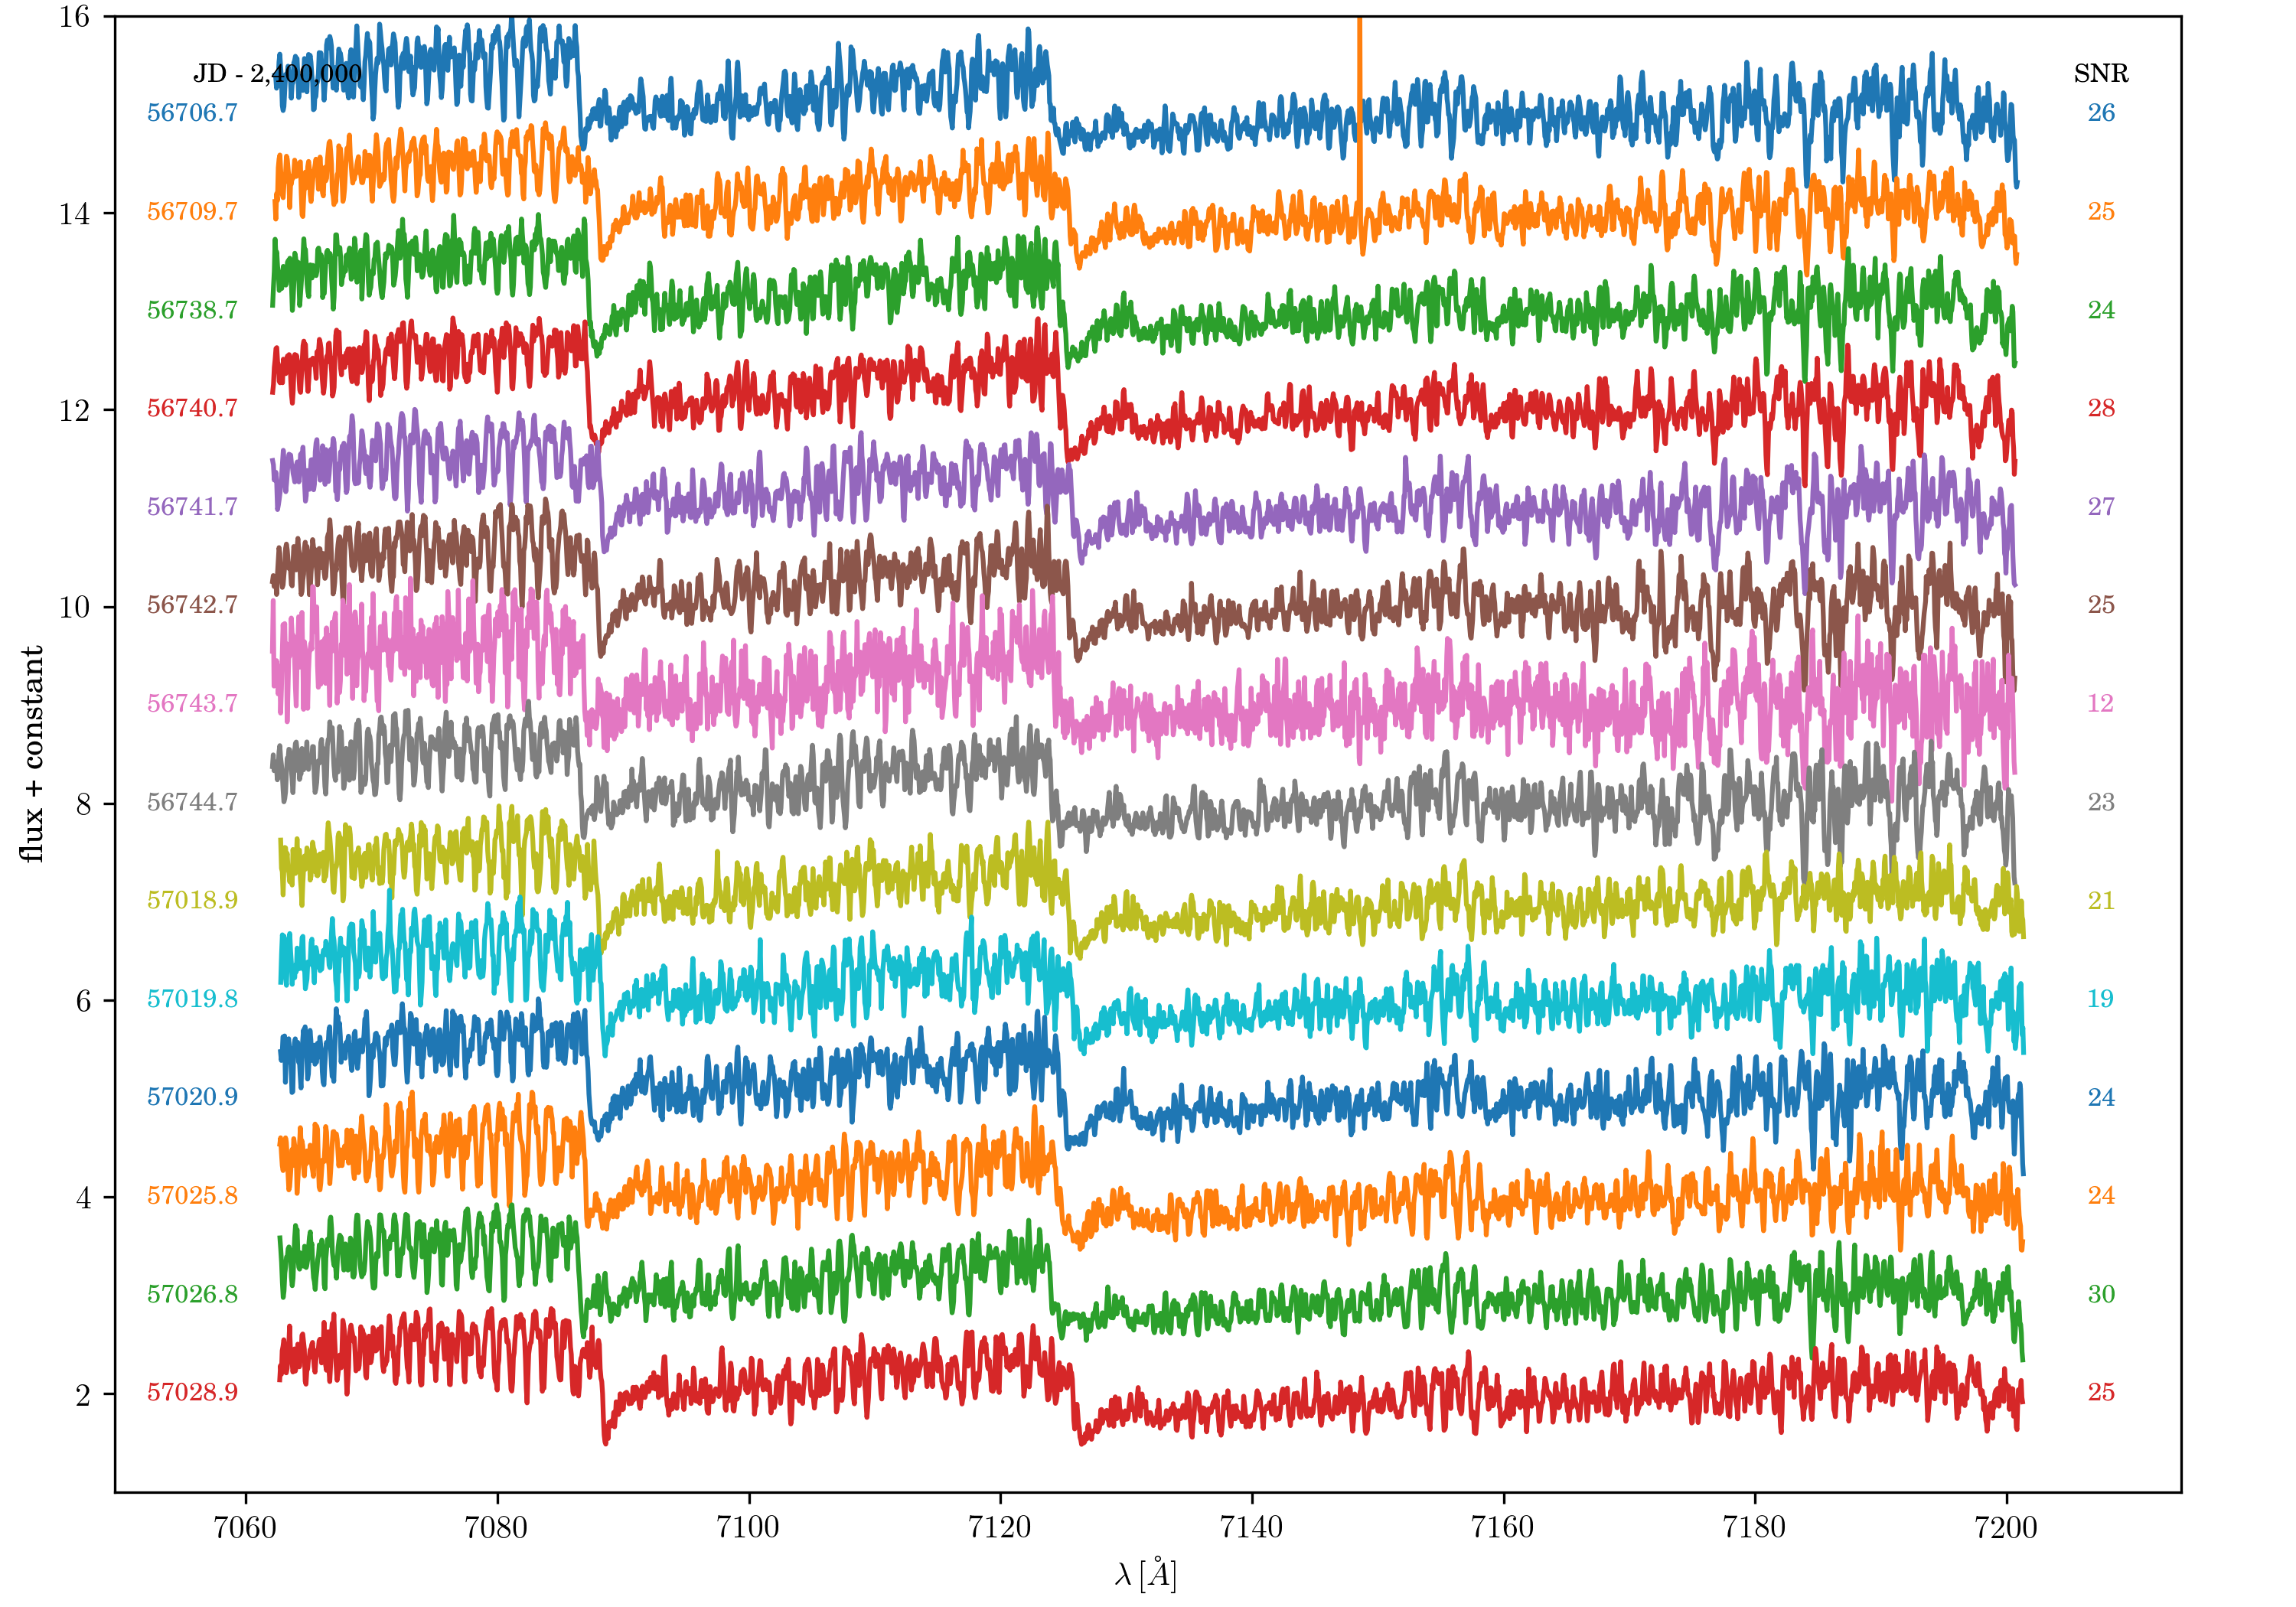

In [8]:
from IPython.display import Image
Image(filename='plots/sort_date/bary/040/all_spectra.png') 

If this is too cramped, we can try adjusting the ``spacing`` parameter to get a better spread. The main takeaways from this visualization are that the spectra are clearly different from epoch to epoch (indicating that there is light from at least two Doppler shifting components) and that we'll need to mask part of the spectrum in the second epoch, since there appears to be a cosmic ray/night sky line outlier.

## Setting up the chunks

Because Gaussian processes are generally very computationally intensive, we'll need to split the spectrum up into chunks so that it can be processed in parallel. The easiest way to get started is to open up the ``chunks.dat`` file with your favorite text editor. 

### Editing the chunks

You should see the following column headings

    order  wl0  wl1

We'll start with two small chunks, which we'll add by hand so that the final contents of ``chunks.dat`` looks like this

    order  wl0  wl1
    40	7080	7090.5
    40	7090	7100.5

In [9]:
# you can also do this automatically like this
!echo "40	7080	7090.5" >> chunks.dat
!echo "40	7090	7100.5" >> chunks.dat

When you are working with many chunks over a wide spectral range, this can get tedious. For these applications, might consider checking out the ``psoap-generate-chunks`` script, with associated help options. You can always edit the resulting ``chunks.dat`` file by hand. The inference procedure is set up so that it's one chunk per CPU core, so generally feel free to use as many chunks as you have CPU cores, since there is no additional time penalty. Depending on the number of epochs of data that you have, you'll probably want to keep each chunk to around 5 - 10 AA in size (for optical spectra).

In [10]:
!psoap-generate-chunks --help

usage: psoap-generate-chunks [-h] [--pixels PIXELS] [--overlap OVERLAP]
                             [--start START] [--end END]

Auto-generate a chunks.dat file, which can be later edited by hand.

optional arguments:
  -h, --help         show this help message and exit
  --pixels PIXELS    Roughly how many pixels per epoch should we have in each
                     chunk?
  --overlap OVERLAP  How many pixels of overlap to aim for between adjacent
                     chunks.
  --start START      Starting wavelength (AA).
  --end END          Ending wavelength (AA).


### Processing the chunks

The next step is to process the data file (``data.hdf5``) into the chunks you specified in ``chunks.dat``. This is done by the ``psoap-process-chunks`` script.

In [11]:
!psoap-process-chunks --help

usage: psoap-process-chunks [-h] [--plot]

Use the demarcated chunks in the chunks.dat to segment the dataset into new
HDF5 chunks.

optional arguments:
  -h, --help  show this help message and exit
  --plot      Make plots of the partitioned chunks.


As you can see, this script is pretty simple. We'll run it with the ``--plot`` option to show the results.

In [15]:
!psoap-process-chunks --plot

Dataset shape (14, 51, 2298)
Processing the following chunks of data
order wl0   wl1  
----- ---- ------
   40 7080 7090.5
   40 7090 7100.5
Processing order 40, wl0: 7080.0, wl1: 7090.5 and limiting to 14 highest S/N epochs.
Processing order 40, wl0: 7090.0, wl1: 7100.5 and limiting to 14 highest S/N epochs.
Limiting to 14 epochs
Limiting to 14 epochs


This produces plots in your toplevel directory which have all of the epochs plotted on top of each other. 

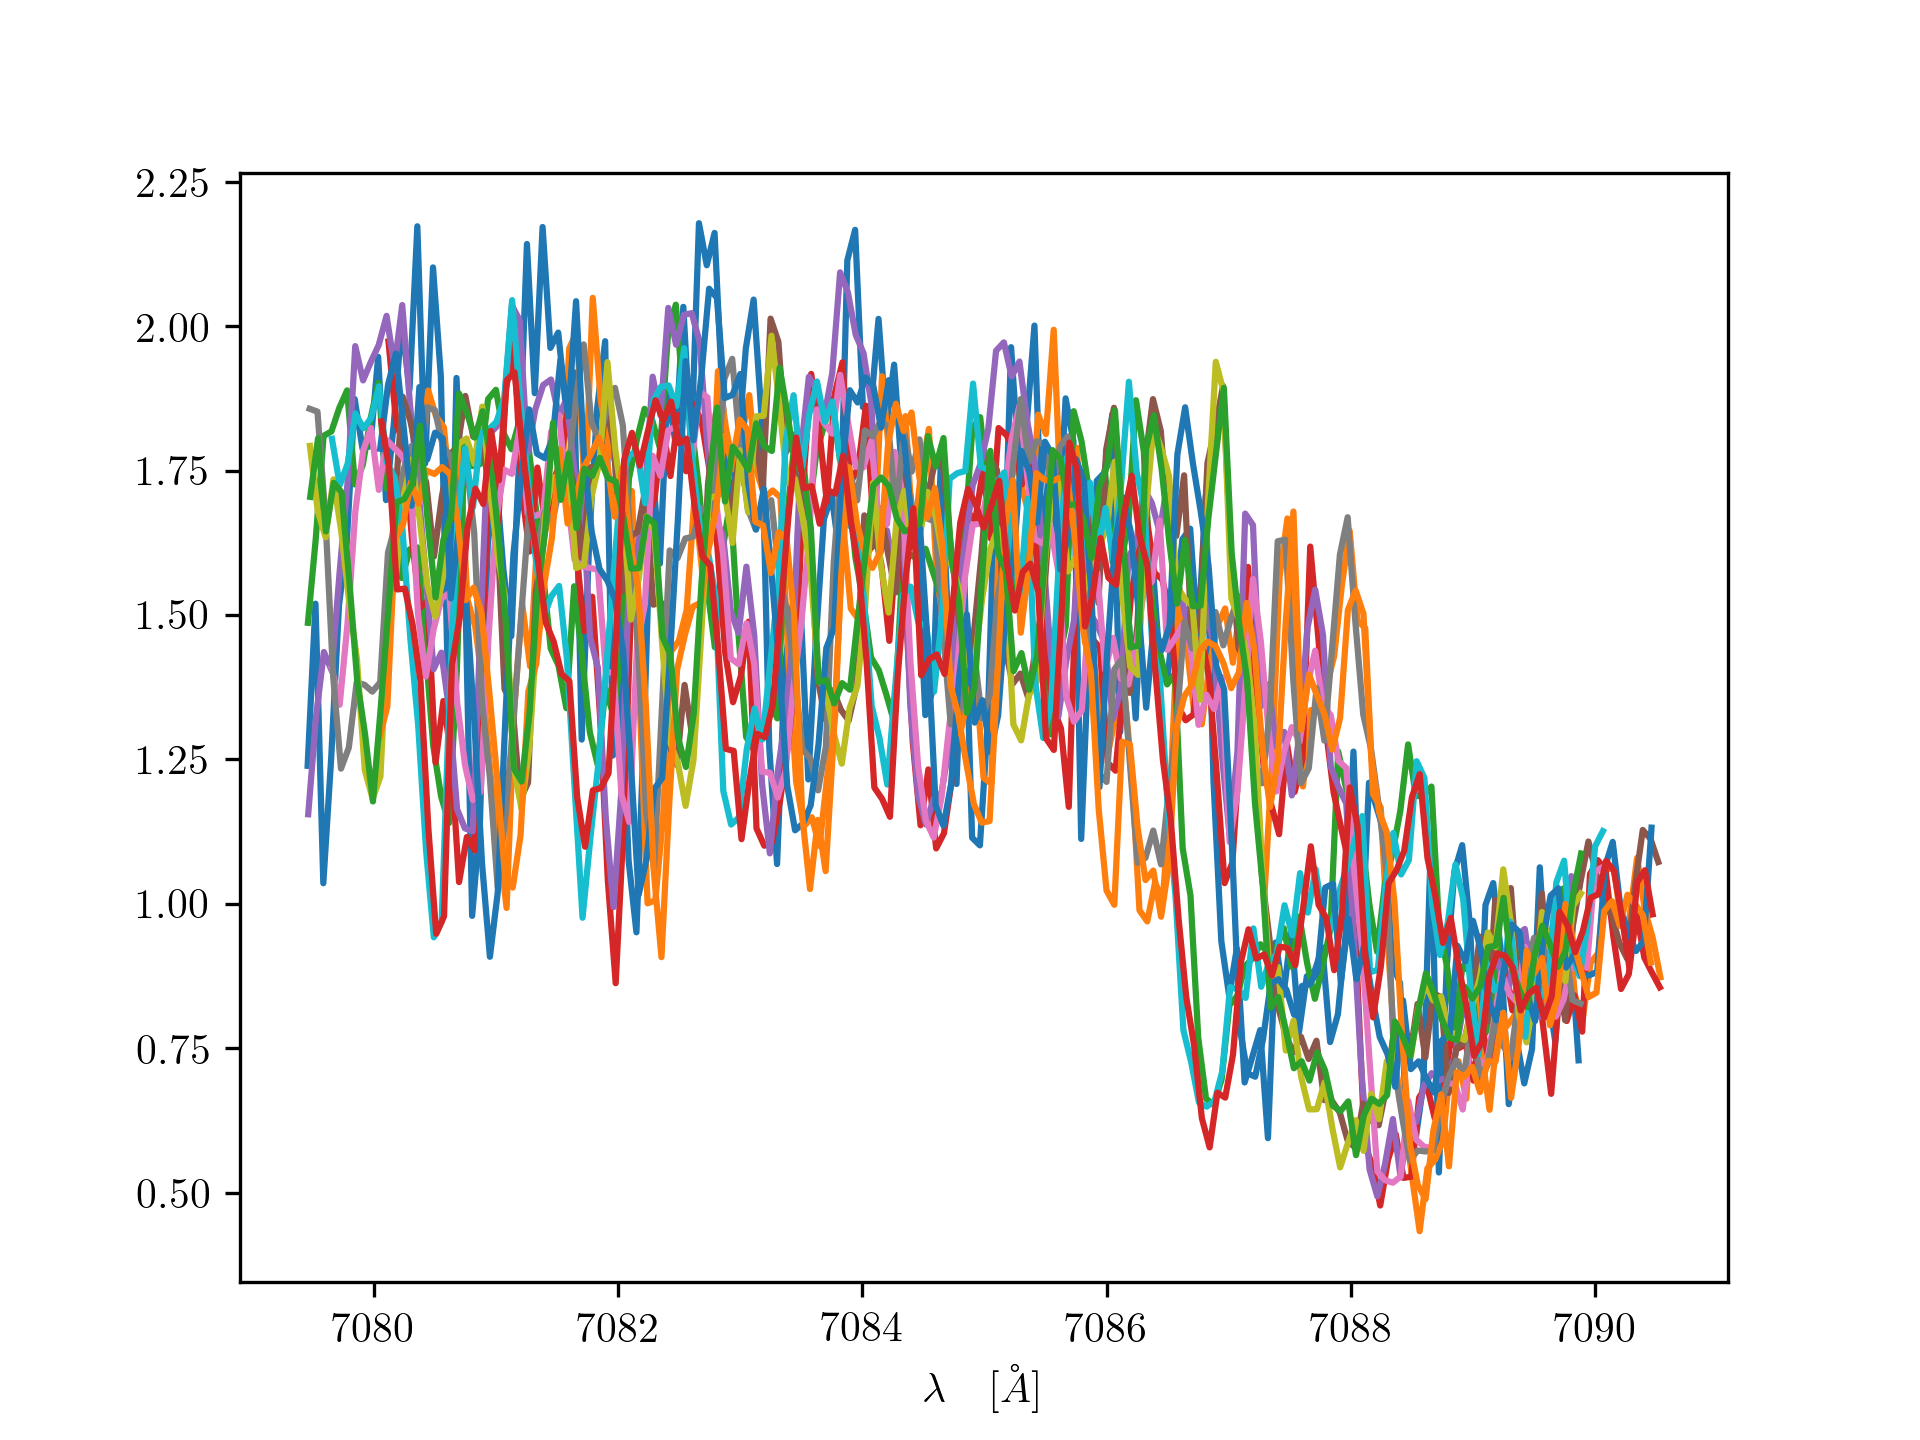

In [18]:
Image(filename='chunk_40_7080_7090.png') 

An inspection of this figure makes it clear that all of the epochs in our chosen chunk are pretty good, so no masking will be required. This routine also produces a directory for the plots for each chunk. Inside of this directory, there is a plot with the spectrum for each epoch on top of the highest signal to noise spectrum in that chunk. This makes it easier to tell if the chunk epoch of spectra are "good," or if there may be an obvious defect like a cosmic ray hit.

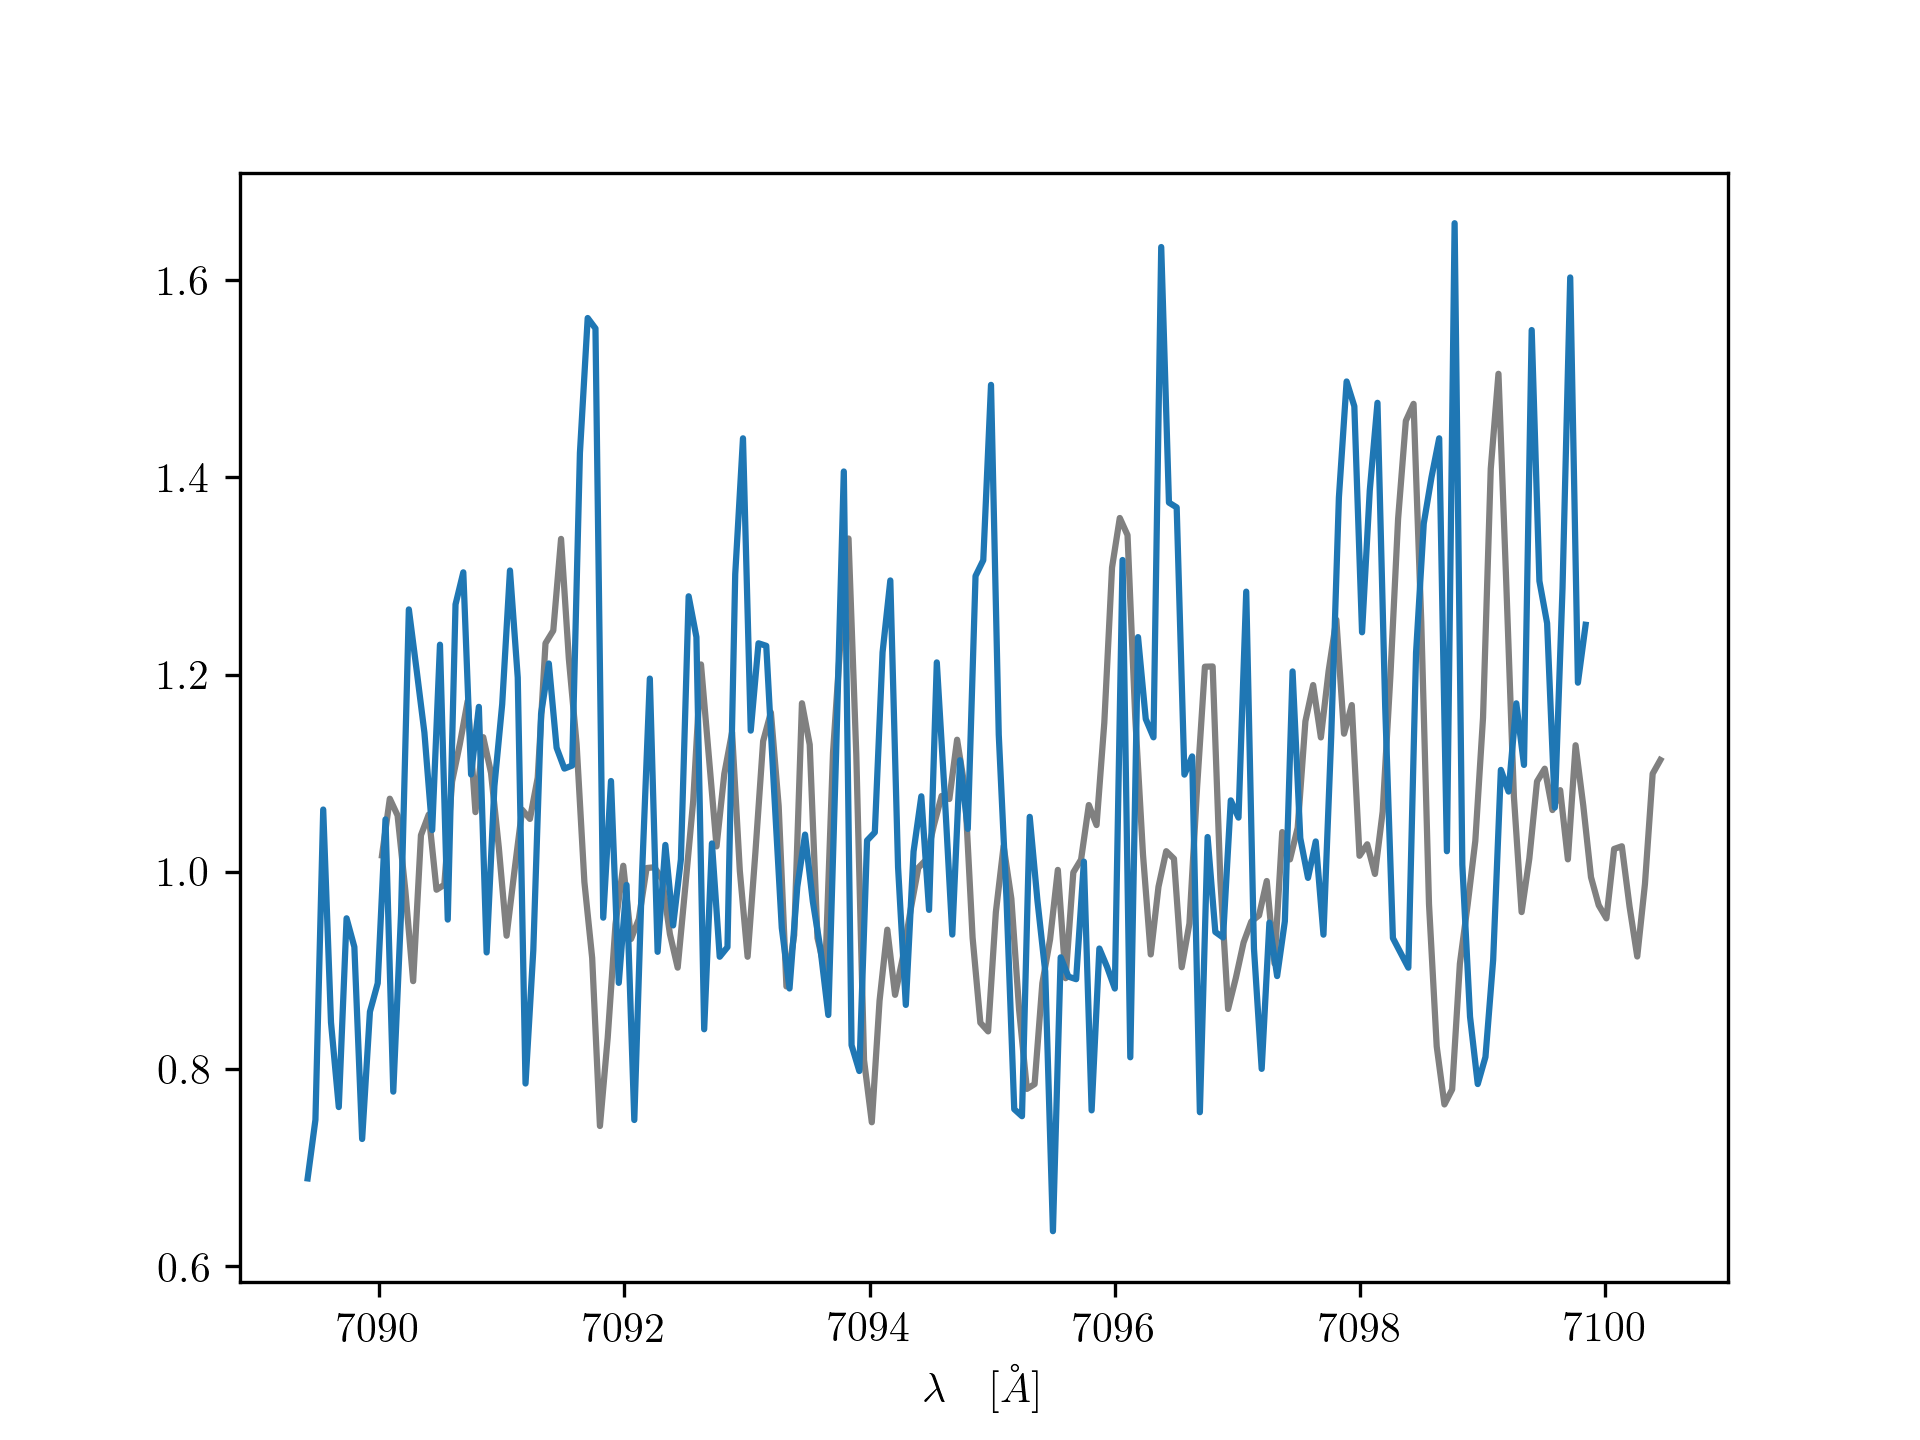

In [19]:
Image(filename='plots_chunk_40_7090_7100/2456743.7.png') 

If you do need to mask your spectrum, check out the ``psoap-generate-masks`` and ``psoap-process-masks`` routines.

## Sampling the parameters 

Now, let's use `PSOAP` to sample the orbital parameters and Gaussian process hyperparameters. In production mode, we would normally do this via 

